In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms, models
from matplotlib import pyplot as plt
import os
from os import path
from PIL import Image
import numpy as np

import sys
sys.path.append(".")
from vgg19 import VGG19

**1.DATA** \
Total of 7 images are provide from which 4 are without any anomalies and 3 of them contains anomalies without any label or segmentation mask.
In this data, anomalies are rare and unstructured and annotating anomalies will not be consistent or scalable. As a result, training a supervised network with ground truth label is not optimal. On the other hand, healthy surfaces are abudant and we train an unsupervised network based on them.

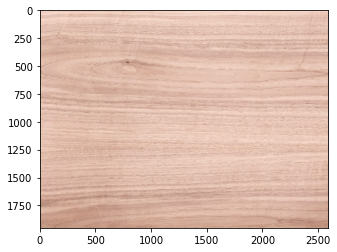

In [2]:
Data_root = './data/'
dataset = datasets.ImageFolder(Data_root)
height,width = dataset[0][0].size
plt.imshow(dataset[0][0]);

**2.Approach** <br>

To handle this problem, we propose a simple autoencoder with MSEloss. To main idea is to train a network to reconstruct healthy parts of the surface. This way, faulty parts can be detected as the difference between input and reconstructed output.<br>

Our pipline startes with a VGG19 as backbone encoder. We only utilize first layer output since the training data is limited. With more data, we can concatenate multiple layers to have a robust encoding. Feature map of the first layer of the VGG19 is the input to a simple autoencoder. Even using first layer of pre-trained backbone leads to more robust results and training. <br>

We train the network only with healthy surfaces (4 images total). For augementation, we used a horizental and vertical random flip and gaussian noise. We have not done any hyper-parameter search as it is not the target of this project.

We got motivations from the following works: <br>
https://github.com/Jimit-Bavishi/extend-ai-ml-assessment
https://arxiv.org/pdf/2012.07122.pdf

In [3]:
class newAE(nn.Module):
    def __init__(self,device) -> None:
        super().__init__()

        self.feature = VGG19().to(device)
        self.device = device
        self.upsample = 'nearest'
        self.cnn_layers = ('relu1_1')
        self.input_dim = 64
        self.latent_dim = 32
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=self.input_dim, out_channels=self.latent_dim, kernel_size=3, stride=2),
            nn.BatchNorm2d(num_features=self.latent_dim),
            nn.ReLU(), # Activation function
            
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=self.latent_dim, out_channels=self.input_dim, kernel_size=3, stride=2, output_padding=1),
            nn.BatchNorm2d(num_features=self.input_dim),
            nn.ReLU()
        )
    
    def forward(self,x):
        B,C,H,W = x.shape
        x = self.feature(x,self.cnn_layers)
        features = torch.Tensor().to(self.device)
        for k,feat_map in x.items():
            feat_map = nn.functional.interpolate(feat_map, size=(H,W), mode=self.upsample, align_corners=True if self.upsample == 'bilinear' else None)
            features = torch.cat([features, feat_map], dim=1)
        x = self.encoder(features)
        x = self.decoder(x)
        return features, x


In [38]:
def train(model,dataloder,device,lr=0.1):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    total_loss = 0
    for data,_ in dataloader:
        data = data.to(device=device)
        model.zero_grad()
        features, pred = model(data)
        loss = criterion(pred, features)
        loss.backward()
        optimizer.step()
        total_loss += loss
    return total_loss

def evaluation(model,dataset,device,preprocess):
    for data,_ in dataset:
        input_img = data
        data = preprocess(data).unsqueeze(0)
        features, output = model.forward(data.to(device=device))
        output_img = (output-features).norm(dim=(1),keepdim=True)[0,0]
        output_img = output_img.detach().cpu().numpy()
        output_img = (output_img-np.min(output_img))/np.ptp(output_img)
#         output_img = (output_img)/output_img.max()
        threshold = .1
        output_img[output_img<threshold] = 0
        output_img[output_img>threshold] = 1
        output_img = Image.fromarray(np.uint8(output_img*255)).convert('P')
        fig = plt.figure(figsize=(20,10))
        ax1 = fig.add_subplot(1,2,1)
        ax1.set_title('Original Image')
        ax1.imshow(input_img)
        ax2 = fig.add_subplot(1,2,2)
        ax2.set_title('Reconstructed Image')
        ax2.imshow(output_img,cmap = plt.get_cmap(name = 'gray'))
        plt.show()

In [5]:
Preprocess = transforms.Compose([
                transforms.RandomCrop(size=(256, 256)),
                transforms.RandomHorizontalFlip(.5),
                transforms.RandomVerticalFlip(.5),
                transforms.GaussianBlur(kernel_size=(3,3)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])])

In [6]:
#hyper_parameters
lr = 0.01
epoch = 2000
batch_size = 4

train_root = './train_data/'
train_set = datasets.ImageFolder(train_root,transform=Preprocess)

device = 'cuda:1'

model = newAE(device=device)
model = model.to(device=device)
dataloader = torch.utils.data.DataLoader(train_set,batch_size=batch_size)

for e in range(epoch):
    epoch_loss = 0
    model.train()
    loss = train(model,dataloader,device,lr)
    epoch_loss += loss
    if e%100 == 0:
        print(f'epoch {e} loss: {epoch_loss}')

torch.save(model.state_dict(), f'final_chkpt.pth')

/home/ali/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch 0 loss: 0.4952244758605957
epoch 100 loss: 0.01101926900446415
epoch 200 loss: 0.011716068722307682
epoch 300 loss: 0.007717464119195938
epoch 400 loss: 0.005011009983718395
epoch 500 loss: 0.00711953965947032
epoch 600 loss: 0.003970760852098465
epoch 700 loss: 0.004069547168910503
epoch 800 loss: 0.0030992114916443825
epoch 900 loss: 0.003222424304112792
epoch 1000 loss: 0.00462193600833416
epoch 1100 loss: 0.0025226806756109
epoch 1200 loss: 0.0021408041939139366
epoch 1300 loss: 0.003128096694126725
epoch 1400 loss: 0.0038112294860184193
epoch 1500 loss: 0.003387774806469679
epoch 1600 loss: 0.002806423231959343
epoch 1700 loss: 0.0024475152604281902
epoch 1800 loss: 0.003848412074148655
epoch 1900 loss: 0.002052677795290947


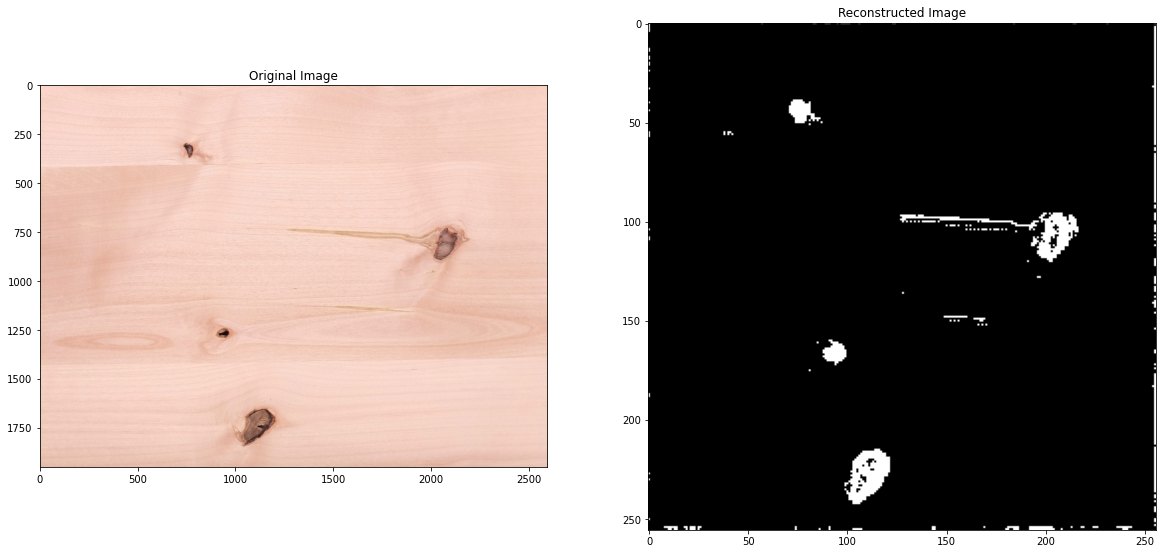

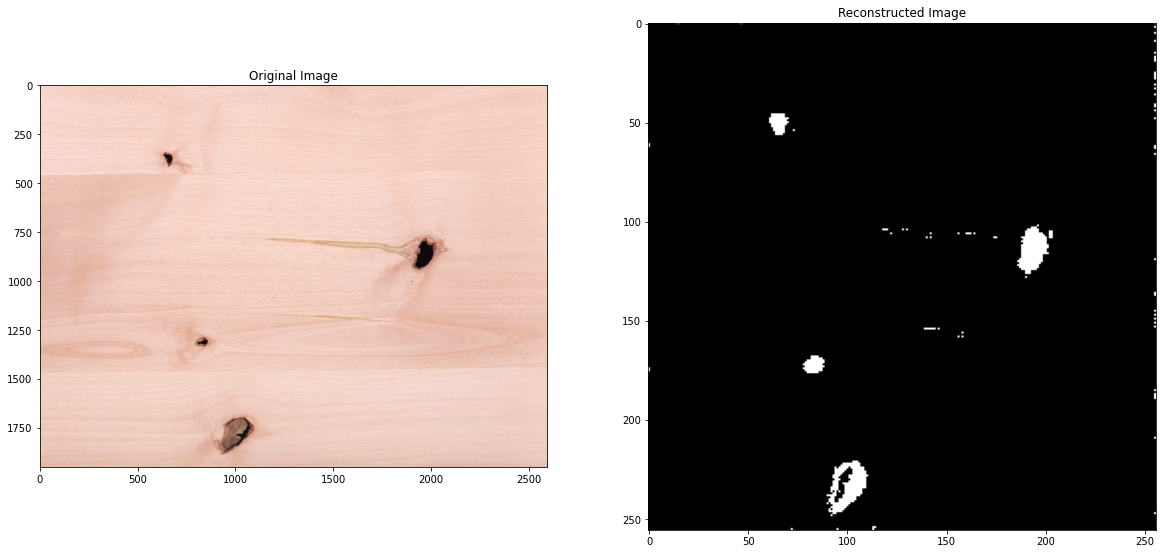

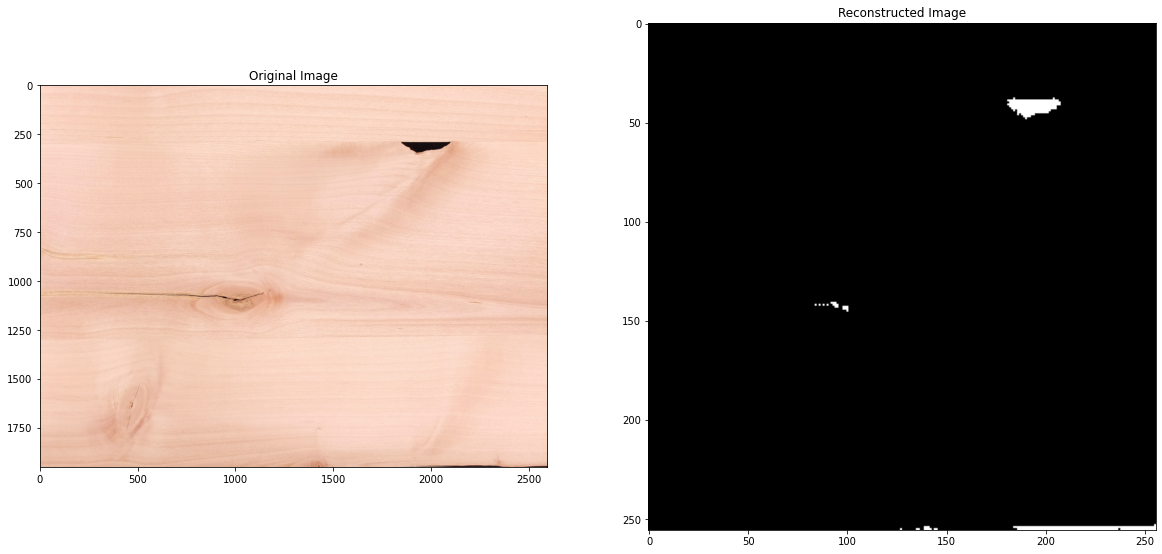

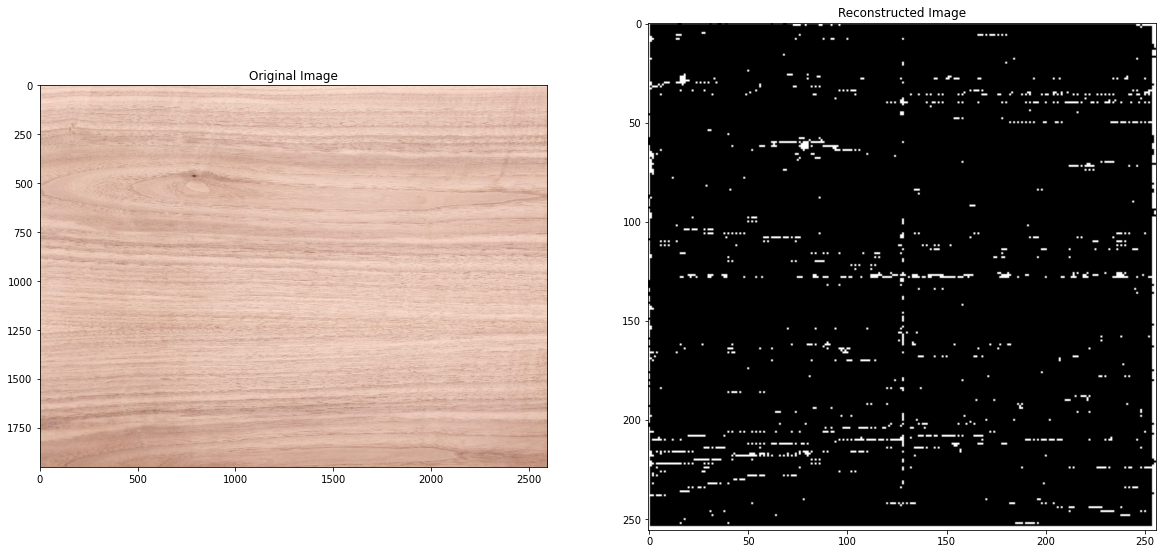

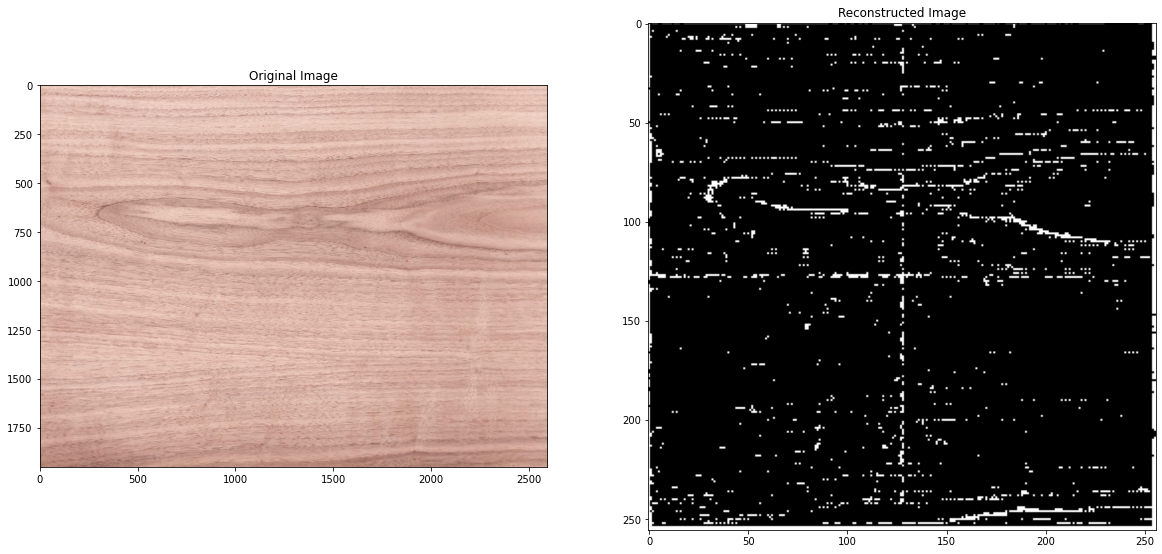

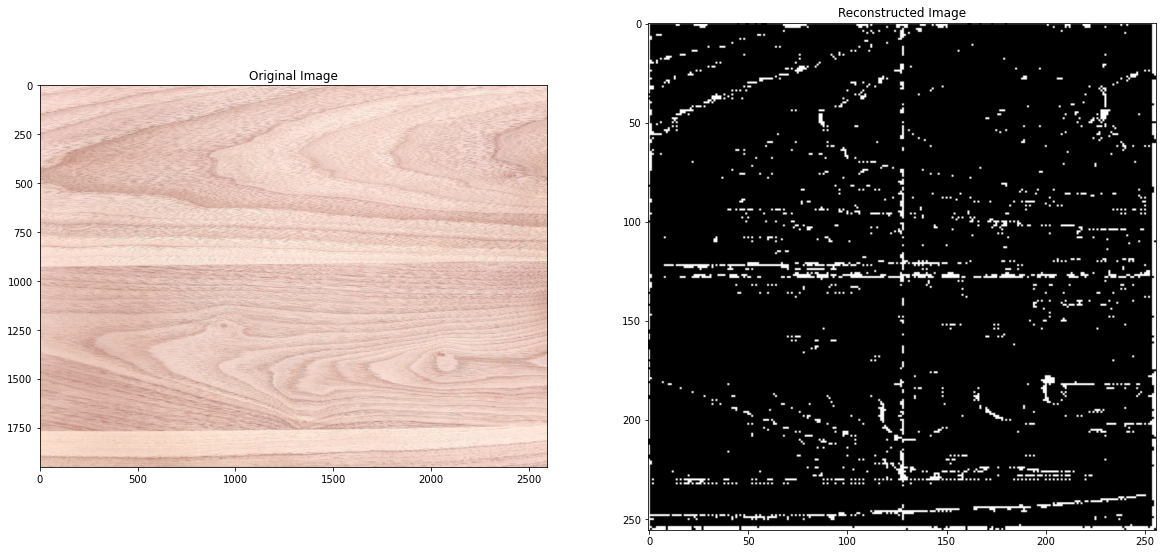

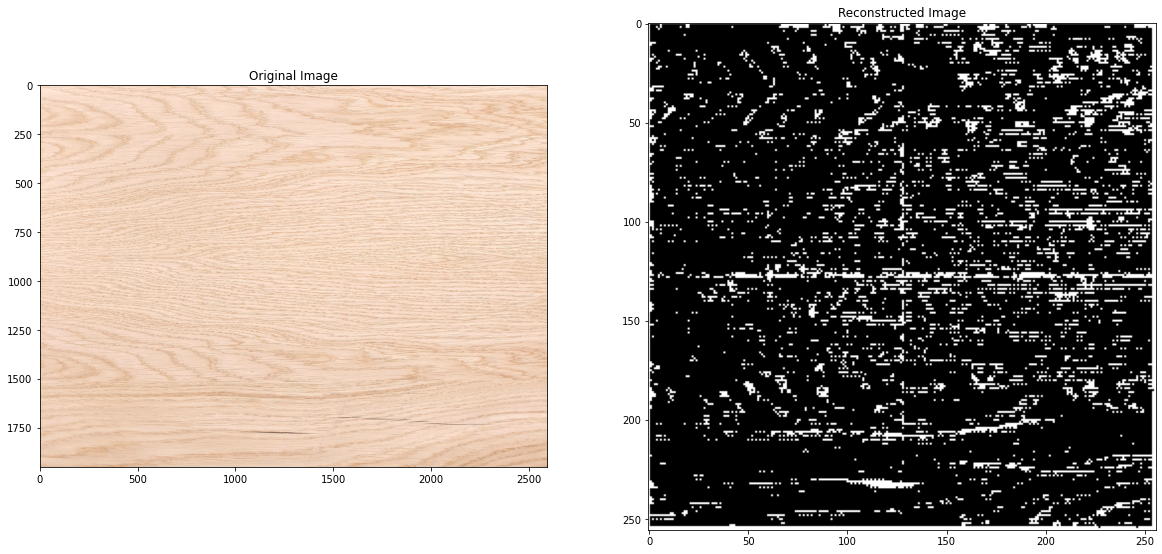

In [39]:
chkpt_path = './final_chkpt.pth'
model.load_state_dict(torch.load(chkpt_path))


test_root = './test_data'
Preprocess_test = transforms.Compose([
                    transforms.Resize(size=(256,256)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225]),
])

test_set = datasets.ImageFolder(test_root)
eval_set = datasets.ImageFolder(train_root)
model.eval()
evaluation(model,test_set,device,Preprocess_test)
evaluation(model,eval_set,device,Preprocess_test)


**3.Analysis and future adaptations** <br>
We were able to train a network which can capture recurring pattern in surface. Our network performs well on knots and spots and partially detects cracks. <br>
However, our model still need more data to successfully discriminate between healty surface and anomalies. <br>
To improve the performance, we can provide more data, employ more complicated augmentation method and increase hard patches in the training set. <br>
To employ this method on other surfaces, we can train from scratch since our autoencoder architecture is simple and minimal.